# STAGE 3: Full Pipeline - Chart Generation and Visual Question Answering

In this notebook we demonstrate an end-to-end pipeline that combines our fine-tuned chart generation (**Stage 1**) and visual question answering (**Stage 2**) models.

## Overview
The fine-tuned **StarCoder2-1B** model takes text descriptions of charts as input and generates Python code to create the corresponding visualizations. Our fine-tuned **Qwen2-VL-2B** will analyzes the generated charts and answers questions about them.

## Pipeline Workflow
### Step 1 - Create Test Examples
- Load the test subset and choose 10 text descriptions of desired charts
- Design questions for each generated chart (format similar to the ones Qwen2-VL-2B was fine-tuned on)
- Manually create ground truth answers based on the charts

### Step 2 - Generate Charts from Descriptions
- Input: 10 text descriptions of charts
- Load the fine-tuned **StarCoder2-1B** from Hugging Face Hub
- Feed descriptions to the fine-tuned StarCoder2-1B model
- Output: 10 Python code snippets that generate matplotlib visualizations

### Step 3 - Execute Code and Save Charts

- Execute the generated code to produce chart images
- Save all generated visualizations as image files
- Evaluate plot generation and image quality

### Step 4 - Visual Question Answering

- Load the fine-tuned **Qwen2-VL-2B** model from Hugging Face Hub
- Feed each chart image with its associated questions to the VQA model
- Collect model predictions for all question-answer pairs

### Step 5 - Evaluation and Analysis

- Compare model predictions against ground truth answers
- Calculate performance metrics including exact match accuracy, relaxed match accuracy, and numeric accuracy
- Analyze the quality of both chart generation and question answering components
- Identify strengths and areas for improvement in the complete pipeline

### Step 6 - Interactive Demo Cell

- Select any generated chart and test the system with different questions

## Step 1 - Create Test Examples
We begin by preparing the baseline reference charts for evaluation and testing. We directly load existing charts from our cleaned ChartGen dataset stored in Drive.

- The dataset is loaded from disk and split into training and test sets.
- We select a small subset of entries from the test set (first10) to inspect and visualize.

For each entry, we display:
- The chart description (summary)
- The associated CSV data (csv)
- The corresponding chart image for visual inspection

- The ground truth chart images are extracted into ground_truth_images for later comparison and evaluation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from dotenv import load_dotenv
import os

# Set path to your .env file in Drive
env_path = "/content/drive/MyDrive/Colab Notebooks/colab_access_token.env"

load_dotenv(env_path)  # Loads variables from your .env file

# Access your Hugging Face token stored in .env as HF_HUB_TOKEN
hf_token = os.getenv("HF_HUB_TOKEN")

#print("Hugging Face Token:", hf_token)  # For debug, remove in production

In [ ]:
from huggingface_hub import login
login(hf_token)

In [ ]:
from datasets import load_dataset
from PIL import Image
from IPython.display import display
import json
import os
import io
import base64
from datasets import load_from_disk

# Load dataset once and split
dataset = load_from_disk("/content/drive/MyDrive/ChartGen_Clean_Dataset")
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
test_set = split_dataset["test"]

Displaying FIRST 10 entries...

Entry 1
Description: The chart is titled "Average Temperature Change Over the Months." The X-axis is labeled "Month" and displays the twelve months of the year (Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec). The Y-axis is labeled "Temperature Change (°C)" and ranges from 0 to approximately 2.5 degrees Celsius. The chart uses a line plot to represent the average temperature change over the months. The line is red in color and is accompanied by filled red area underneath it, which adds to the visual representation of the data. Data points are marked with small red circles and are annotated with their respective values. The line and data points follow a general upward trend from January to June, then a downward trend from June to December.
Data: Month,Temperature Change (°C)
Jan,2.1
Feb,1.9
Mar,1.5
Apr,1.2
May,0.9
Jun,0.6
Jul,0.5
Aug,0.6
Sep,0.9
Oct,1.2
Nov,1.5
Dec,1.9


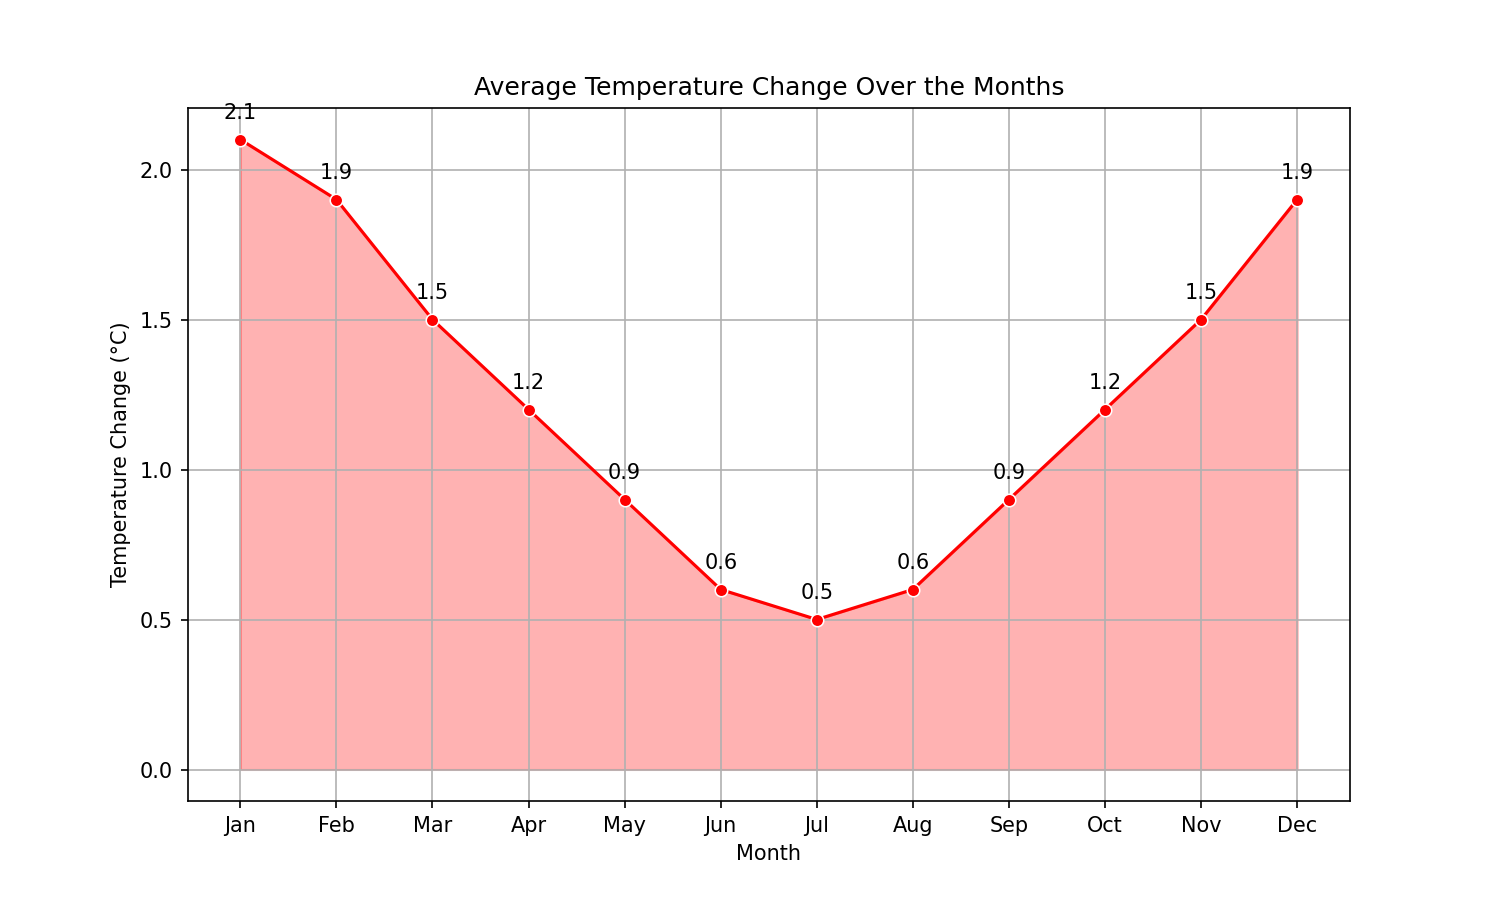

Entry 2
Description: The chart title is "United States and China opinions of each other." The X-axis is labeled "Year" and shows data from 2005 to 2019. The Y-axis is labeled "Percentage" and ranges from 0 to 65. The chart uses stacked area plots to compare the favorability of the United States in China and China in the United States over time. The area plot for United States favorability in China is displayed in a sky blue color, while the area plot for China favorability in the United States is displayed in an orange color. The data points for each year are connected by lines to form the area plots. The chart does not provide specific values for each data point, but it shows a general trend of decreasing favorability over time for both countries.
Data: Year,United States favorability in China,China favorability in United States
2005,65,55
2007,62,52
2009,60,48
2011,58,45
2013,56,42
2015,54,38
2017,52,35
2019,50,30


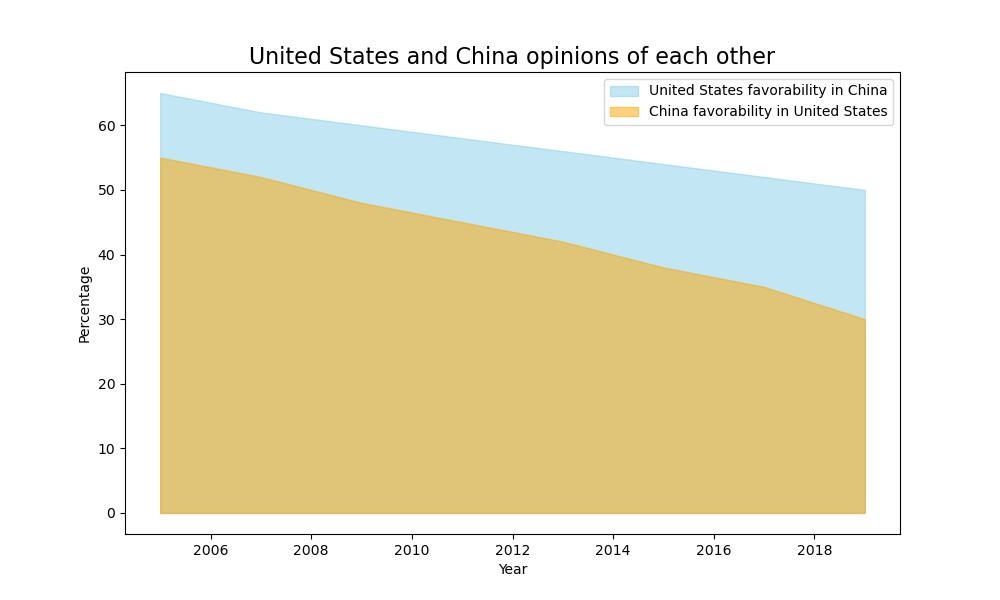

Entry 3
Description: The chart is a pie chart titled "Fruit Quantity Distribution." It displays the distribution of five types of fruits: Apples, Bananas, Oranges, Grapes, and Mangoes. The size of each slice of the pie represents the proportion of each fruit in the total quantity. The chart uses different colors to distinguish between the fruits. The largest slice represents Apples, which make up 30% of the total quantity. Bananas make up 25%, Oranges 20%, Grapes 15%, and Mangoes 10%. The chart does not provide any information about the absolute quantity of each fruit.
Data: Fruit,Quantity
Apples,30
Bananas,25
Oranges,20
Grapes,15
Mangoes,10


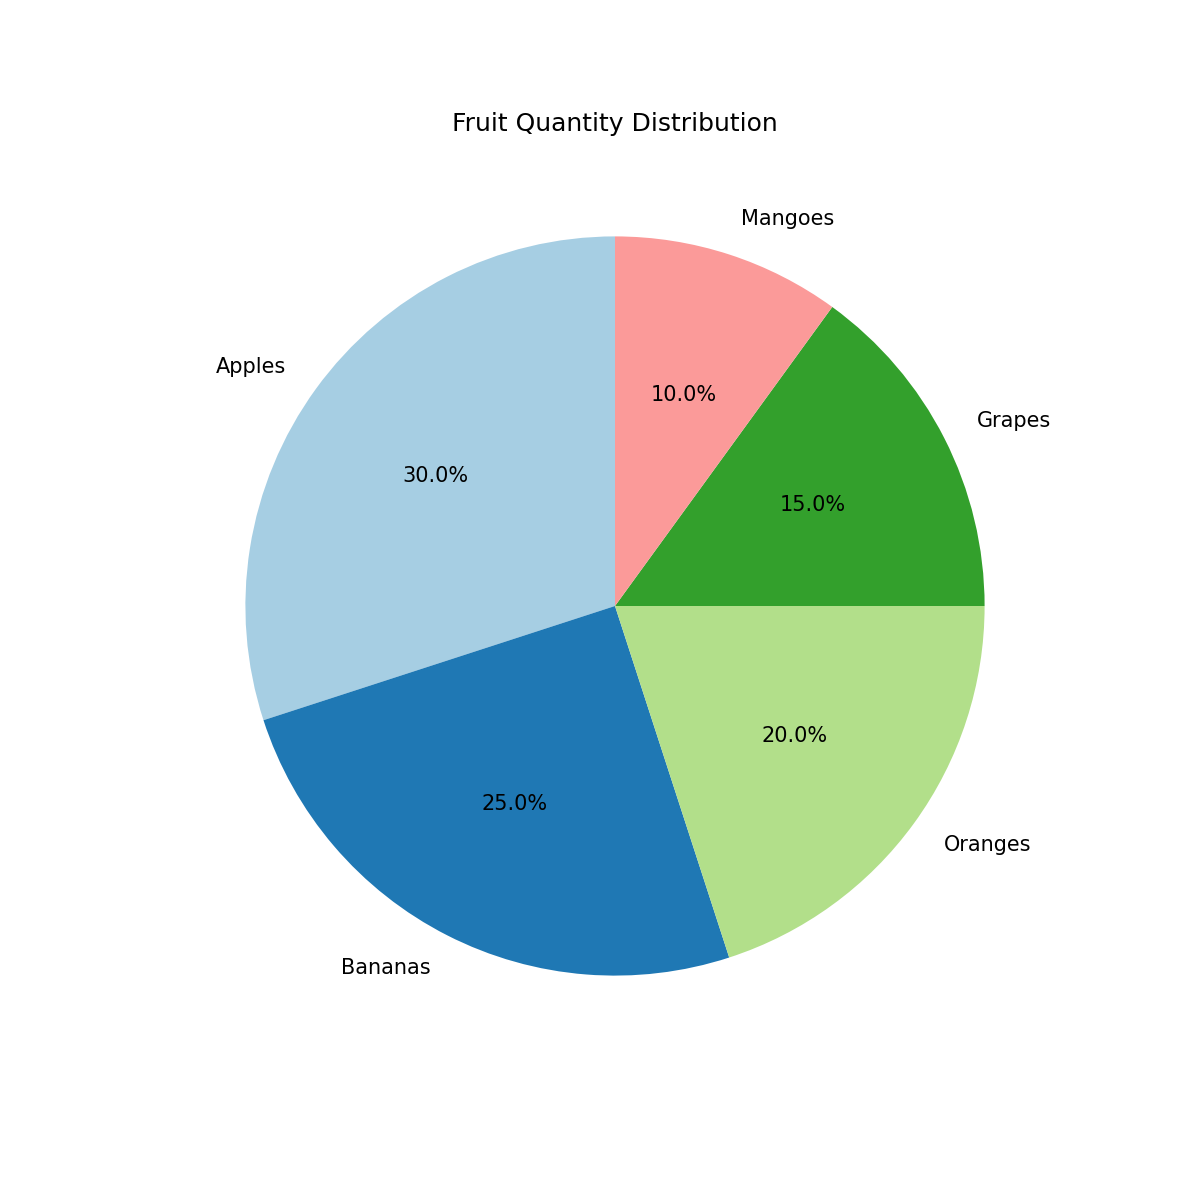

Entry 4
Description: The chart is a line chart titled "Sales Trend Over Time." The X-axis is labeled "Month" and displays the categories January (Jan), February (Feb), March (Mar), April (Apr), May, June (Jun), and July (Jul). The Y-axis is labeled "Sales" and ranges from approximately 90 to 180. The chart uses a line to represent the sales trend over time, with data points marked by green circles. The sales values for each month are 100 for Jan, 120 for Feb, 90 for Mar, 150 for Apr, 180 for May, 130 for Jun, and 110 for Jul.
Data: Month,Sales
Jan,100
Feb,120
Mar,90
Apr,150
May,180
Jun,130
Jul,110


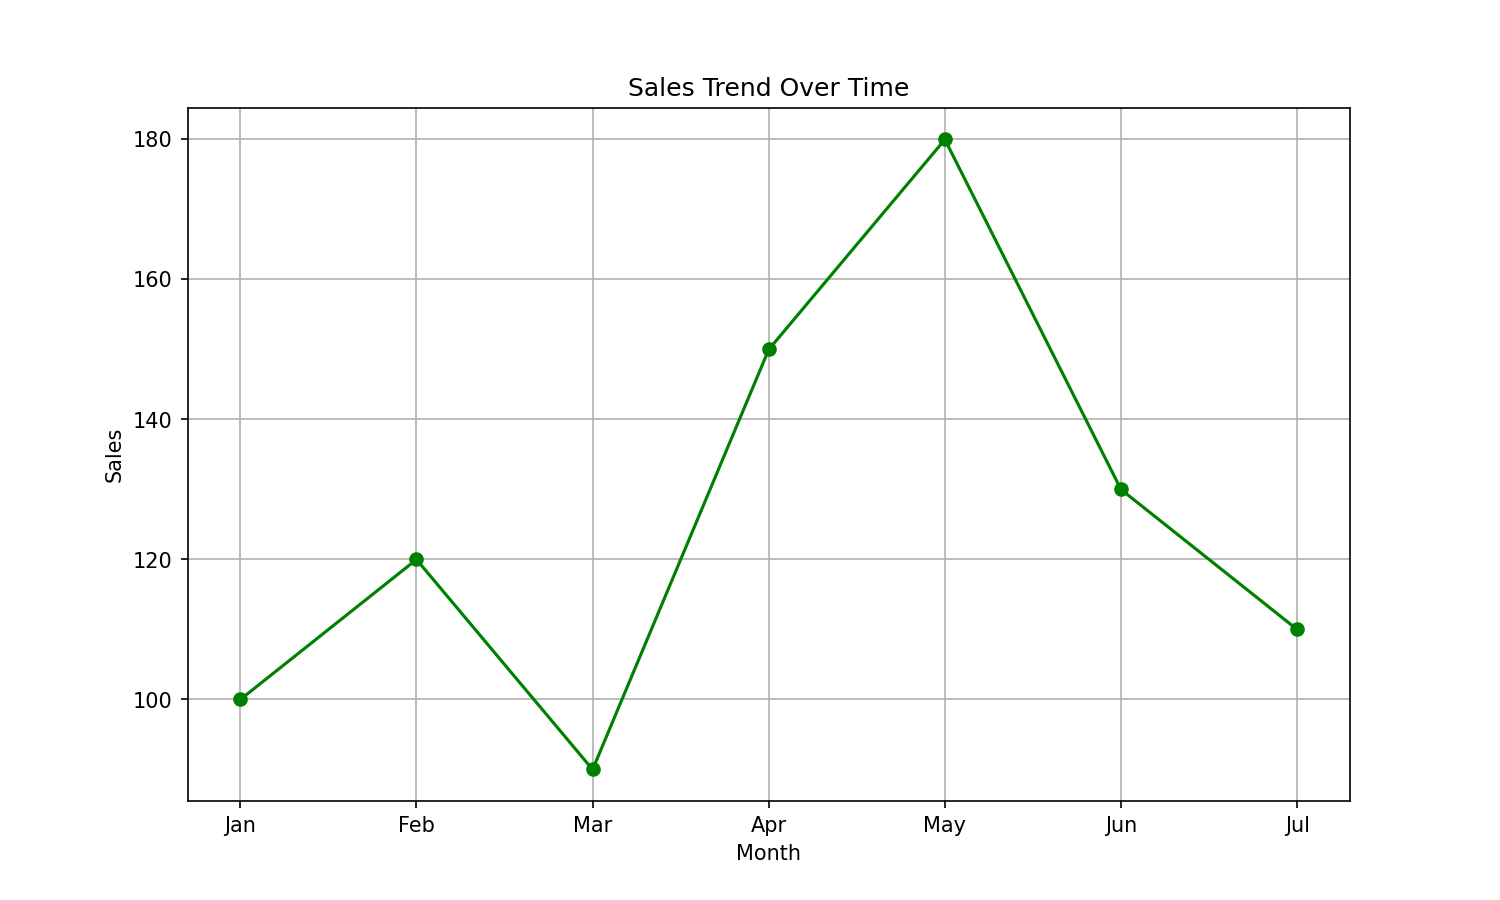

Entry 5
Description: The chart is a line chart titled "Sales and Expenses Over the Years." The X-axis is labeled "Year" and displays the years 2015, 2016, 2017, 2018, and 2019. The Y-axis is labeled "Amount" and ranges from approximately 8000 to 14000. The chart uses two lines to compare the Sales and Expenses over the years. The blue line represents the Sales, with values of 10000, 12000, 11000, 13000, and 14000 for the years 2015, 2016, 2017, 2018, and 2019, respectively. The red line represents the Expenses, with values of 8000, 9000, 8500, 10000, and 11000 for the same years, respectively.
Data: Year,Sales,Expenses
2015,10000,8000
2016,12000,9000
2017,11000,8500
2018,13000,10000
2019,14000,11000


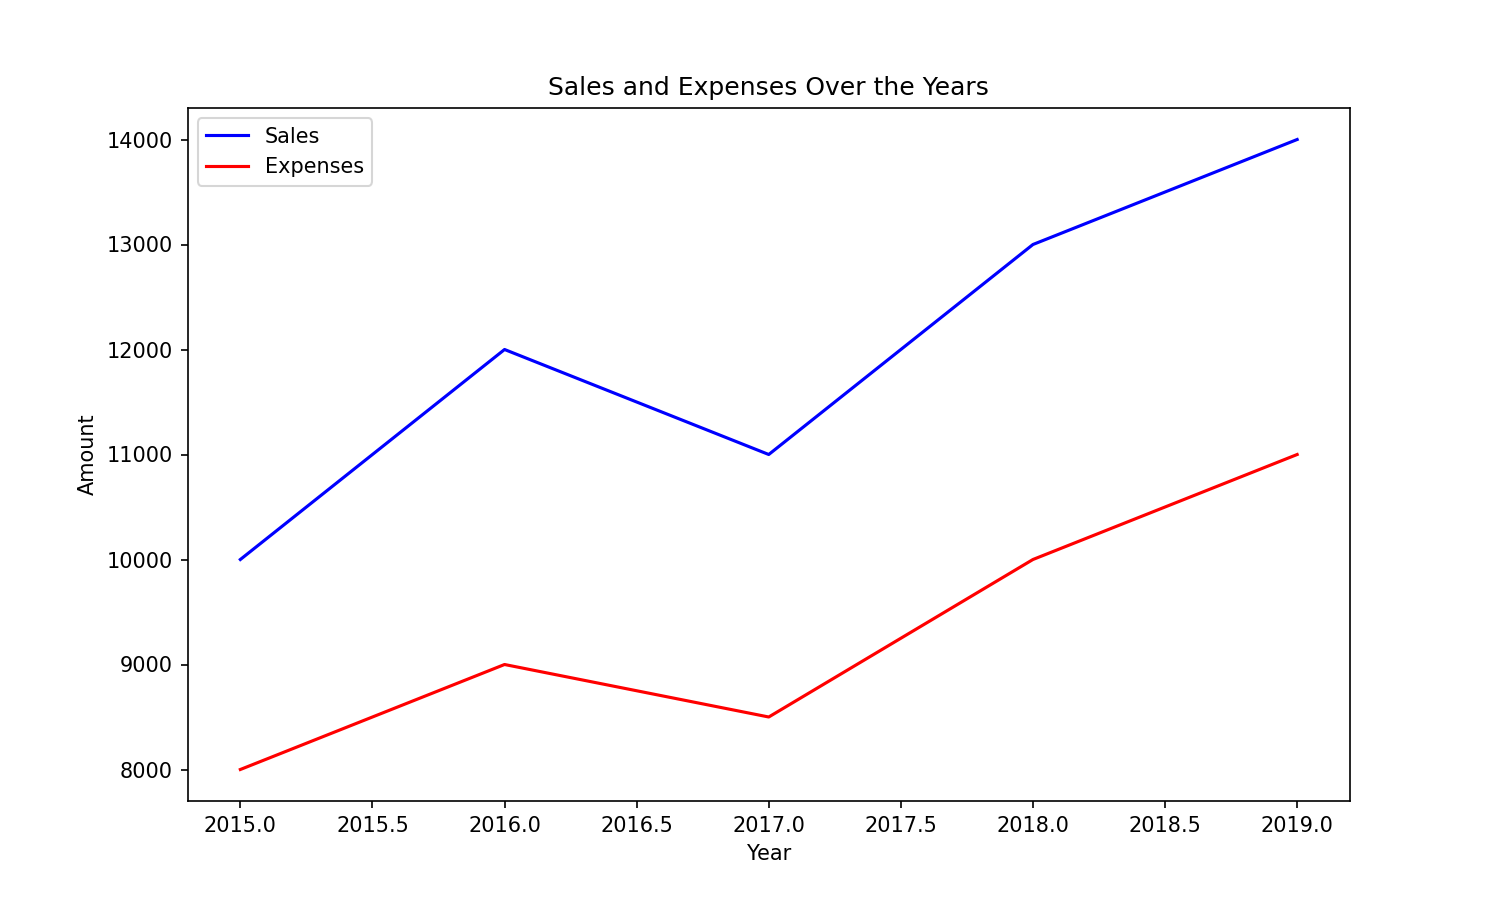

Entry 6
Description: The chart is a rose chart, also known as a circular pie chart, titled "Popularity of Python Web Frameworks." It displays the popularity percentage of ten different Python web frameworks in a circular format. The frameworks are labeled on the chart, and each slice of the pie represents the percentage of popularity for a specific framework. The color of each slice varies to differentiate between the frameworks. The chart does not have a traditional x-axis or y-axis as it is a circular representation of data. The frameworks included in the chart are Django, Flask, FastAPI, Tornado, Bottle, Pyramid, Web2py, CherryPy, TurboGears, and Quart. The popularity percentages are not explicitly mentioned in the chart, but the size of each slice can be used to infer the relative popularity of each framework.
Data: Framework,Popularity (%)
Django,25.6
Flask,21.3
FastAPI,14.7
Tornado,10.2
Bottle,7.8
Pyramid,6.5
Web2py,4.2
CherryPy,3.9
TurboGears,3.5
Quart,2.8


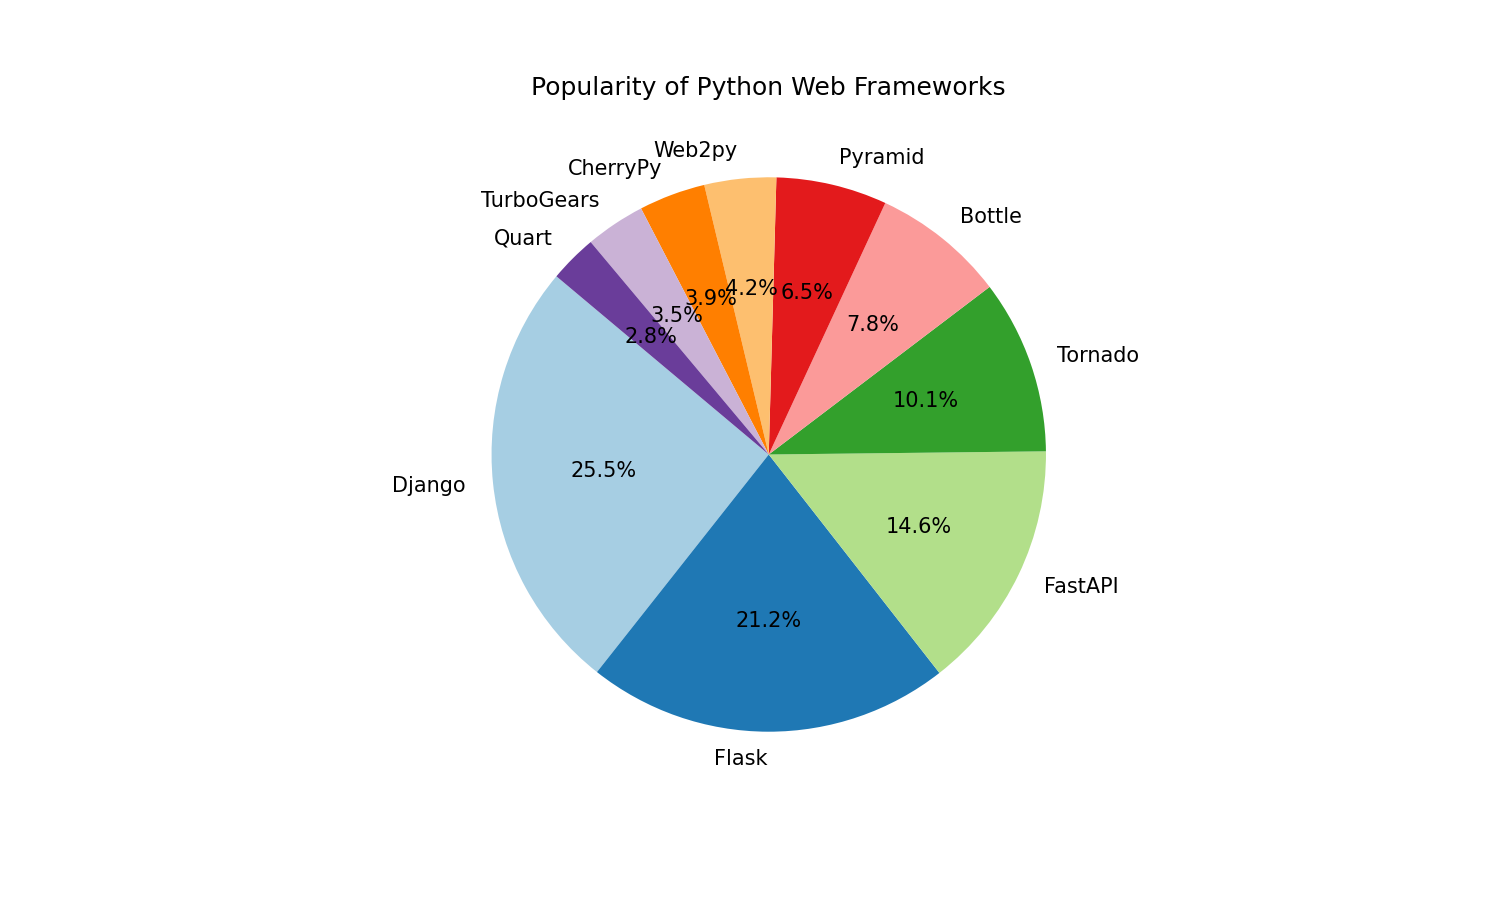

Entry 7
Description: The chart is a line chart titled "City Temperature Over the Years." The X-axis is labeled "Year" and shows the years 2010 to 2014. The Y-axis is labeled "Temperature" and ranges from approximately 22 to 32 degrees. The chart uses lines with circular markers to compare the temperature trends over time for three cities: CityX, CityY, and CityZ. The line for CityX starts at around 25 degrees in 2010 and increases to about 29 degrees in 2014. The line for CityY starts at around 28 degrees in 2010 and increases to about 32 degrees in 2014. The line for CityZ starts at around 22 degrees in 2010 and increases to about 26 degrees in 2014.
Data: Year,Temperature_CityX,Temperature_CityY,Temperature_CityZ
2010,25,28,22
2011,26,29,23
2012,27,30,24
2013,28,31,25
2014,29,32,26


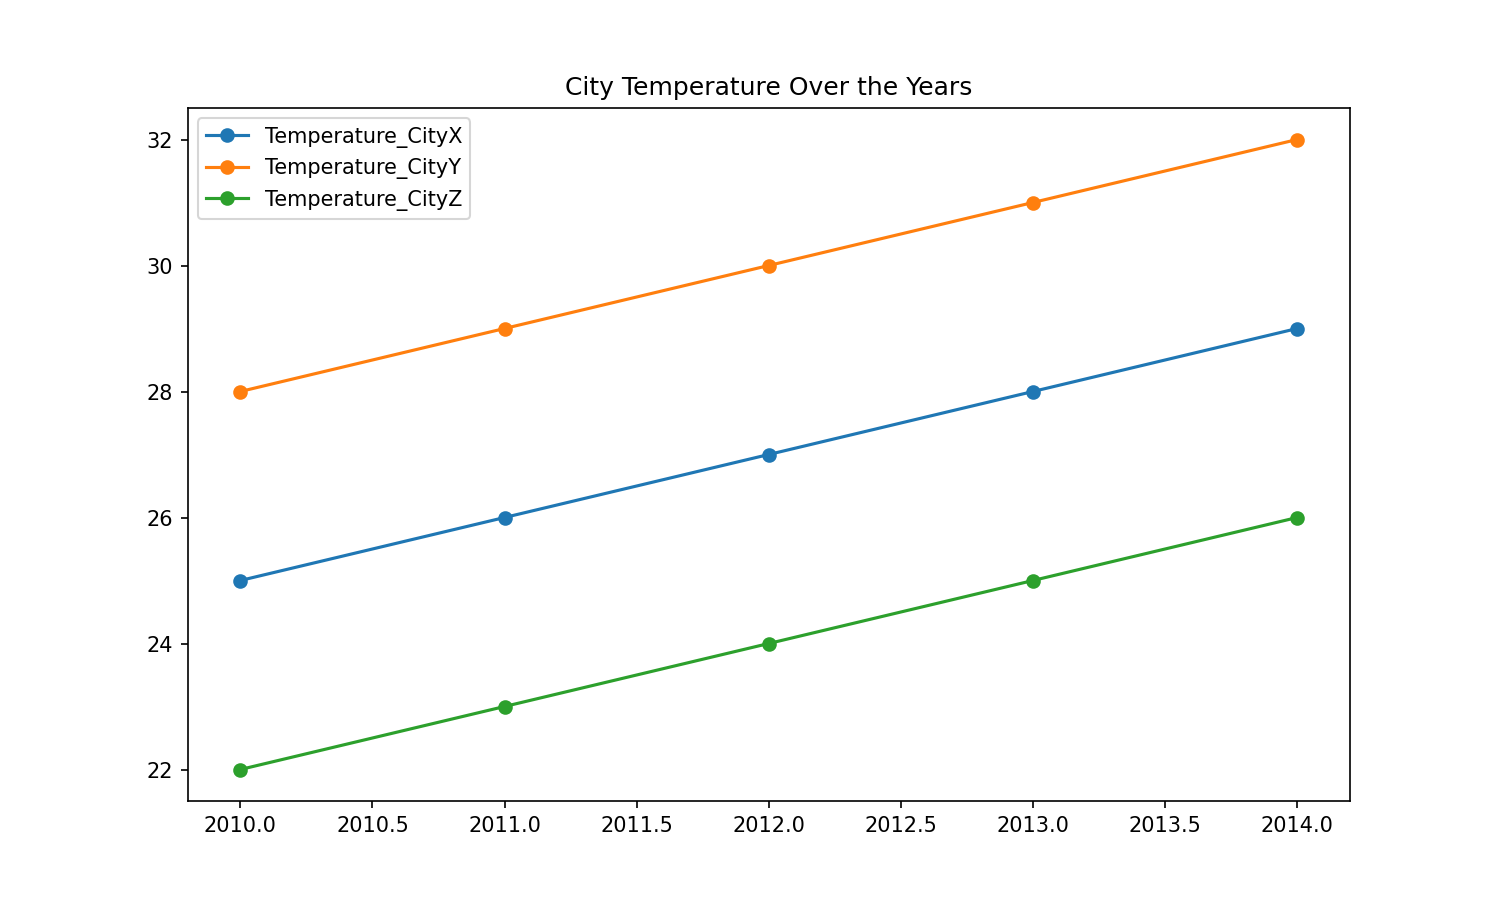

Entry 8
Description: The chart is a scatter plot titled "Product Profits Over the Years." The X-axis is labeled "Years" and displays the years from 2015 to 2020. The Y-axis is labeled "Profit (in thousands)" and ranges from 0 to approximately 60. The chart uses two different colors to represent the profits of two products: green for Product A and red for Product B. The scatter plot shows the profit of each product for each year, allowing for a visual comparison of the two products' performance over time.
Data: Years,Product_A_Profit,Product_B_Profit
2015,30,20
2016,35,25
2017,40,30
2018,45,35
2019,50,40
2020,55,45


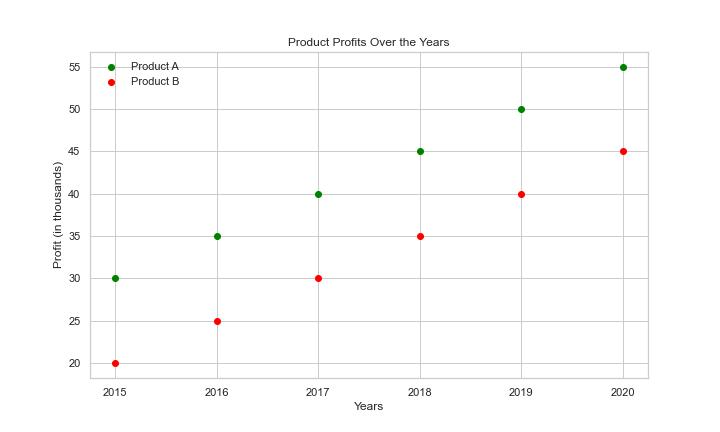

Entry 9
Description: The chart is titled "World Population Growth Over the Years." The X-axis is labeled "Year" and displays the years from 2010 to 2020. The Y-axis is labeled "Population Growth (in Millions)" and ranges from approximately 6.8 to 7.8 million. The chart uses an area chart to represent the population growth over the years. The area under the line is filled with a light sky blue color, and the line itself is navy blue. The chart does not include any additional data series or comparisons.
Data: Year,Population Growth (in Millions)
2010,6.8
2011,6.9
2012,7.0
2013,7.1
2014,7.2
2015,7.3
2016,7.4
2017,7.5
2018,7.6
2019,7.7
2020,7.8


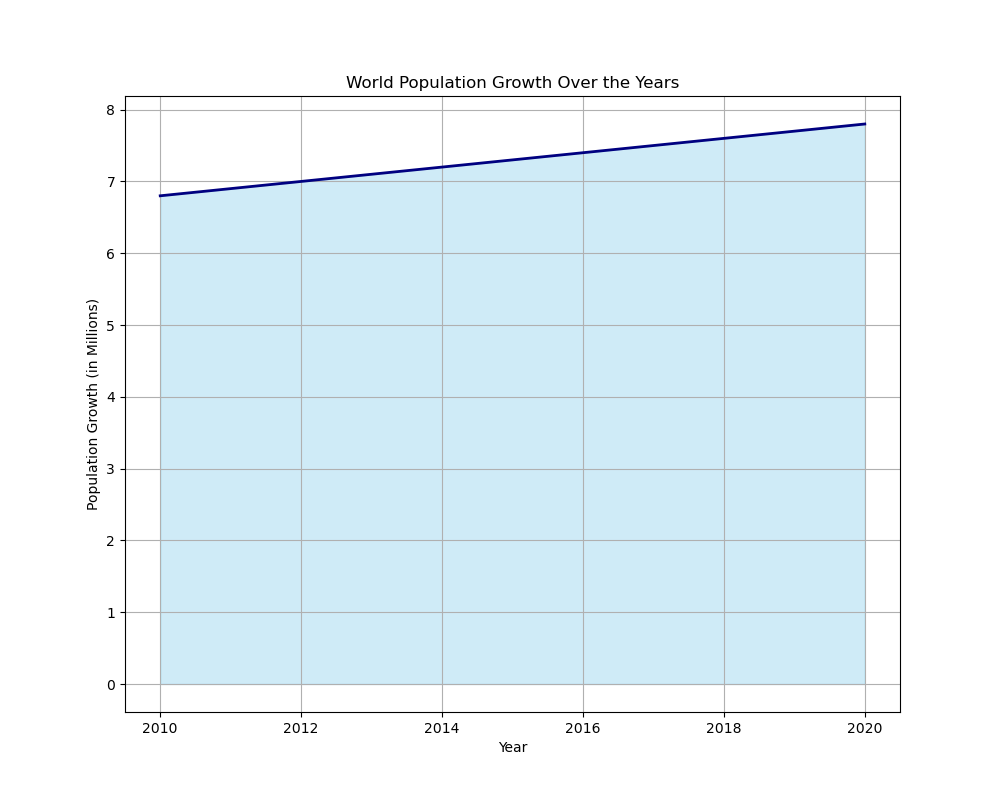

Entry 10
Description: The chart is titled "Annual Revenue of Companies A and B." The X-axis is labeled "Year" and displays the years from 2015 to 2020. The Y-axis is labeled "Revenue (in millions)" and ranges from 0 to approximately 250. The chart uses area charts to compare the annual revenue of Companies A and B over the six-year period. The area under the line representing Company A is filled with a light sky blue color, while the area under the line representing Company B is filled with a light green color. The revenue values for Company A are 120, 150, 180, 200, 220, and 250 for the years 2015 to 2020, respectively. The revenue values for Company B are 80, 100, 120, 140, 160, and 180 for the same period.
Data: Year,Revenue_Company_A,Revenue_Company_B
2015,120,80
2016,150,100
2017,180,120
2018,200,140
2019,220,160
2020,250,180


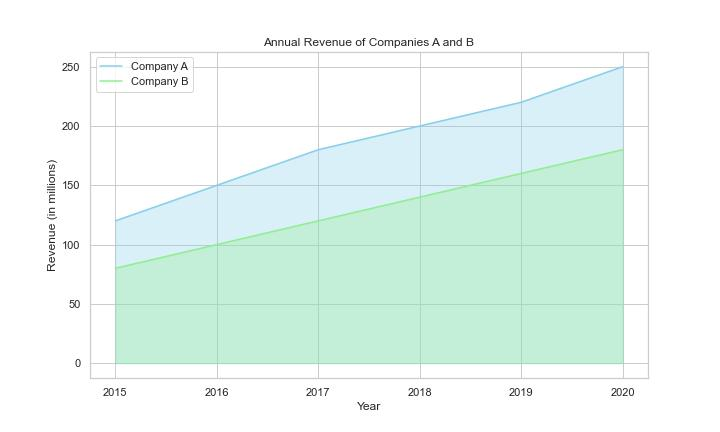

In [ ]:
first10 = dataset.select(range(2, 12))

# ------------------------------------------------------
# DISPLAY FIRST 10 ENTRIES
# ------------------------------------------------------
print("Displaying FIRST 10 entries...\n")


for i, item in enumerate(first10):
    print("=====================================")
    print(f"Entry {i+1}")

    # description text
    print("Description:", item["summary"])
    print("Data:", item["csv"])

    # display image (ChartGen stores raw bytes in "image")
    img = item["image"]
    display(img)


In [ ]:
ground_truth_images = first10["image"]

In [ ]:
print(first10)

Dataset({
    features: ['id', 'code', 'image', 'image_path', 'summary', 'csv', 'doctags', 'question_answers'],
    num_rows: 10
})


## Prepare Q&A Pairs
Now we construct the structured data needed for evaluating our models on chart-related questions.

- We define a set of question-answer pairs (qa_pairs) corresponding to the first 10 charts from the dataset.
- For each chart, we combine its description, CSV data, and the associated question into a single dictionary (model_data).

- Separately store:
    - answers as a list of dictionaries with the ground truth answers
    - questions as a list of dictionaries with the question texts

- We extract descriptions and CSV data into selected_data for easier access.
- And lastly, we reorganize selected_data into raw_model_data, a list of dictionaries, each containing a description and data entry, ready to feed into model evaluation or interactive Q&A.

In [ ]:
qa_pairs = [
    {"question": "What is the temperature change in July?",
      "answer": "0.5"},
    {"question": "Is United States favourability in China more than China favourability in United States?",
      "answer": "Yes"},
    {"question": "What is the quantity proportion of Mangoes?",
      "answer": "10"},
    {"question": "Which month had the most sales?",
      "answer": "May"},
    {"question": "What is the Sales amount in Year 2016?",
      "answer": "12000"},
    {"question": "What is the popularity of Django?",
      "answer": "25.5"},
    {"question": "When was the highest city temperature in CityY?",
      "answer": "2014"},
    {"question": "Is profit of product A more than profit of product B in 2018?",
      "answer": "Yes"},
    {"question": "What was the population growth in 2012?",
      "answer": "7"},
    {"question": "Is the annual revenue of company B more than annual revenue of company A in 2016?",
      "answer": "No"}
]


In [ ]:
model_data = []
answers = []
questions = []
for i, qa in enumerate(qa_pairs):
    item = first10[i]  # or dataset_subset[i] if using a subset
    one_item = {
        "description": item["summary"],
        "data": item["csv"],
        "question": qa["question"]
    }
    one_answer = {"answer": qa["answer"]}
    one_question = {"question": qa["question"]}

    model_data.append(one_item)
    answers.append(one_answer)
    questions.append(one_question)


In [ ]:
descriptions = [item["description"] for item in model_data]
data_entries = [item["data"] for item in model_data]

selected_data = {
    "description": descriptions,
    "data": data_entries
}


In [ ]:
keys = selected_data.keys()
num_samples = len(selected_data["description"])  # assume all lists same length

raw_model_data = [
    {key: selected_data[key][i] for key in keys}
    for i in range(num_samples)
]


## Step 3 - Execute Code and Save Charts

In this step, we apply our fine-tuned StarCoder model to generate Python chart code from chart descriptions and CSV data.

- We load the LoRA fine-tuned StarCoder model and tokenizer.
- Define helper functions for robust code handling:
    - extract_code_clean — extracts valid Python chart code from generated text
    - add_grid_to_code — ensures charts include grid lines where appropriate
    - check_syntax / check_compilation — verify generated code is syntactically correct
    - execute_and_capture_plot — runs code and captures the resulting chart as an image
    - compare_images — optionally compares generated charts against ground truth using metrics like SSIM, PSNR, and MSE

- Implement a StopOnString stopping criterion to avoid code generation going beyond intended outputs.
- Define the main evaluation function evaluate_model_data which:
    - Iterates through the dataset or subset of samples
    - Generates chart code for each description and CSV data
    - Extracts and validates the Python code
    - Executes the code to produce charts
    - Collects metrics on syntax, compilation, execution success, and visual similarity
    - Records failed or gibberish generations for debugging
    - Optionally saves successfully generated charts to disk

This establishes the automated pipeline for producing charts from textual descriptions and structured data, while providing extensive error handling and metrics collection for both qualitative and quantitative evaluation.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

MODEL_NAME = "dormosol/starcoderbase-chartgen-lora"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/986 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

FUNCTIONS FOR RUNNING 1ST MODEL ON DATA

In [ ]:
import ast
import io
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from collections import defaultdict
from tqdm import tqdm
from transformers import StoppingCriteriaList, StoppingCriteria


# ======================================================================
# HELPER FUNCTIONS
# ======================================================================


def should_skip_grid(code: str) -> bool:
    """Check if chart type doesn't need grid lines."""
    no_grid_patterns = [
        r'plt\.pie\(',
        r'ax\.pie\(',
        r'projection=["\']polar["\']',
        r'polar=True',
        r'\.violinplot\(',
        r'sns\.violinplot\(',
        r'squarify\.',
        r'treemap\(',
    ]
    return any(re.search(pattern, code) for pattern in no_grid_patterns)


def is_valid_python_code(code: str) -> bool:
    """Check if code looks like valid Python (not gibberish)."""
    if not code or len(code) < 20:
        return False

    python_indicators = ['plt.', 'import', 'def', '=', 'np.', 'pd.', 'for ', 'if ']
    has_python = any(indicator in code for indicator in python_indicators)

    has_non_ascii_start = any(ord(c) > 127 for c in code[:50])
    has_too_many_slashes = code.count('//') > 3
    has_chinese = any('\u4e00' <= c <= '\u9fff' for c in code[:100])

    return has_python and not (has_non_ascii_start or has_too_many_slashes or has_chinese)


def extract_code_clean(generated_text: str) -> str:
    """Extract Python code from model output with validation."""
    # Strategy 1: Look for code after "### Code:" marker
    if "### Code:" in generated_text:
        code_parts = generated_text.split("### Code:")
        if len(code_parts) > 1:
            code_section = code_parts[-1]
            if "###" in code_section:
                code = code_section.split("###")[0]
            else:
                code = code_section

            code = code.strip()

            if is_valid_python_code(code):
                return add_grid_to_code(code)
            else:
                print(f"WARNING: Extracted text is not valid Python code")
                return ""

    # Strategy 2: Look for markdown code fences
    triple_backtick = '`' * 3
    python_fence = triple_backtick + 'python'

    if python_fence in generated_text:
        parts = generated_text.split(python_fence)
        if len(parts) > 1:
            code = parts[1].split(triple_backtick)[0].strip()
            if is_valid_python_code(code):
                return add_grid_to_code(code)

    # Strategy 3: Try to find import statements
    if 'import' in generated_text:
        lines = generated_text.split('\n')
        code_lines = []
        in_code = False

        for line in lines:
            if 'import' in line and not in_code:
                in_code = True
            if in_code:
                if line.strip().startswith('###') or line.strip().startswith('# Output'):
                    break
                code_lines.append(line)

        code = '\n'.join(code_lines).strip()
        if is_valid_python_code(code):
            return add_grid_to_code(code)

    return ""


def add_grid_to_code(code: str) -> str:
    """Add plt.grid(True) to code if needed."""
    if not code or should_skip_grid(code):
        return code

    if "plt.grid(" in code or "ax.grid(" in code:
        return code

    show_pattern = r'plt\.show\(\)'
    savefig_pattern = r'plt\.savefig\('

    show_match = None
    savefig_match = None

    for match in re.finditer(show_pattern, code):
        show_match = match
    for match in re.finditer(savefig_pattern, code):
        savefig_match = match

    insert_pos = None
    if show_match and savefig_match:
        insert_pos = min(show_match.start(), savefig_match.start())
    elif show_match:
        insert_pos = show_match.start()
    elif savefig_match:
        insert_pos = savefig_match.start()

    if insert_pos is not None:
        line_start = code.rfind('\n', 0, insert_pos)
        if line_start == -1:
            line_start = 0
        else:
            line_start += 1

        indent = ''
        for char in code[line_start:insert_pos]:
            if char in ' \t':
                indent += char
            else:
                break

        code = code[:line_start] + f"{indent}plt.grid(True)\n" + code[line_start:]
    else:
        code += "\nplt.grid(True)"

    return code


def check_syntax(code: str) -> bool:
    """Check if code has valid Python syntax."""
    if not code:
        return False
    try:
        ast.parse(code)
        return True
    except SyntaxError:
        return False


def check_compilation(code: str) -> bool:
    """Check if code compiles."""
    if not code:
        return False
    try:
        compile(code, "<string>", "exec")
        return True
    except Exception:
        return False


def check_chart_components(code: str) -> dict:
    """Check for common chart elements in code."""
    if not code:
        return {
            "has_plot_call": 0,
            "has_xlabel": 0,
            "has_ylabel": 0,
            "has_title": 0,
            "has_legend": 0,
            "has_grid": 0,
            "skipped_grid": 0,
            "code_length": 0,
        }

    return {
        "has_plot_call": int(any(x in code for x in ["plt.plot", "plt.bar", "plt.scatter", "plt.pie", "plt.hist", "plt.line"])),
        "has_xlabel": int("xlabel" in code),
        "has_ylabel": int("ylabel" in code),
        "has_title": int("title" in code),
        "has_legend": int("legend" in code),
        "has_grid": int("grid" in code),
        "skipped_grid": int(should_skip_grid(code)),
        "code_length": len(code),
    }


import re

def execute_and_capture_plot(code: str, debug=False):
    """
    Execute Python chart code and return an RGB image.
    Handles both matplotlib and pandas plotting.
    Returns: (success: bool, image_array: np.ndarray | None, error_msg: str | None)
    """
    if not code or not code.strip():
        if debug:
            print("DEBUG: Empty or no code")
        return False, None, "Empty or no code"

    try:
        plt.close("all")

        # CRITICAL FIX: Remove plt.close() and plt.show() calls that destroy the figure
        code_clean = code
        code_clean = re.sub(r'\bplt\.close\([^)]*\)', '', code_clean)  # Remove plt.close() or plt.close('all')
        code_clean = re.sub(r'\bplt\.show\(\)', '', code_clean)

        if debug:
            if code != code_clean:
                print("DEBUG: Removed plt.close() and/or plt.show() calls")
            print(f"DEBUG: Executing code:\n{code_clean}\n")

        namespace = {
            "__builtins__": __builtins__,
            "plt": plt,
            "np": __import__("numpy"),
            "pd": __import__("pandas"),
        }

        # Execute the code
        exec(code_clean, namespace)

        # Check all figures (handles multiple figures or pandas plots)
        all_figs = [plt.figure(n) for n in plt.get_fignums()]

        if debug:
            print(f"DEBUG: Number of figures created: {len(all_figs)}")

        if not all_figs:
            if debug:
                print("DEBUG: No figures created at all")
            return False, None, "No figures created"

        # Use the last created figure (most likely to be the main plot)
        fig = all_figs[-1]

        if debug:
            print(f"DEBUG: Using figure {plt.get_fignums()[-1]}, has {len(fig.get_axes())} axes")

        if not fig.get_axes():
            if debug:
                print("DEBUG: No axes in figure")
                print(f"DEBUG: Figure size: {fig.get_size_inches()}")
            return False, None, "No axes created"

        # Capture the plot
        buf = io.BytesIO()
        fig.savefig(buf, format="png", dpi=120, bbox_inches="tight")
        buf.seek(0)
        image = Image.open(buf).convert("RGB")
        img_array = np.array(image)

        if debug:
            print(f"DEBUG: Image captured, shape: {img_array.shape}")
            print(f"DEBUG: Image stats - min: {img_array.min()}, max: {img_array.max()}, mean: {img_array.mean():.2f}")

        # Check if image is blank (all white)
        if np.all(img_array == 255):
            if debug:
                print("DEBUG: Generated blank white image")
            plt.close("all")
            return False, None, "Blank image generated"

        # Check if image has very low variance (likely blank)
        if img_array.std() < 1.0:
            if debug:
                print(f"DEBUG: Image has very low variance ({img_array.std():.3f})")
            plt.close("all")
            return False, None, "Blank or uniform image"

        if debug:
            print(f"DEBUG: ✓ Success! Image shape: {img_array.shape}")
            try:
                from IPython.display import display
                display(image)
            except:
                pass

        plt.close("all")
        return True, img_array, None

    except Exception as e:
        plt.close("all")
        if debug:
            import traceback
            print(f"DEBUG: Execution error: {str(e)}")
            traceback.print_exc()
        return False, None, str(e)



def compare_images(img1, img2):
    """
    Compare two images using SSIM, PSNR, and MSE.
    Handles both numpy arrays and PIL Images.
    """
    try:
        from skimage.metrics import structural_similarity as ssim
        from skimage.metrics import peak_signal_noise_ratio as psnr
        HAS_SKIMAGE = True
    except ImportError:
        HAS_SKIMAGE = False

    try:
        # Convert PIL Images to numpy arrays if needed
        if hasattr(img1, 'convert'):  # It's a PIL Image
            img1 = np.array(img1.convert('RGB'))
        if hasattr(img2, 'convert'):  # It's a PIL Image
            img2 = np.array(img2.convert('RGB'))

        # Ensure both are numpy arrays
        if not isinstance(img1, np.ndarray):
            img1 = np.array(img1)
        if not isinstance(img2, np.ndarray):
            img2 = np.array(img2)

        if img1.shape != img2.shape:
            if HAS_SKIMAGE:
                from skimage.transform import resize
                img2 = resize(img2, img1.shape, anti_aliasing=True)
                img2 = (img2 * 255).astype(np.uint8)
            else:
                return None

        if HAS_SKIMAGE:
            from skimage.color import rgb2gray
            img1_gray = rgb2gray(img1) if len(img1.shape) == 3 else img1
            img2_gray = rgb2gray(img2) if len(img2.shape) == 3 else img2
            ssim_score = ssim(img1_gray, img2_gray, data_range=1.0)
            psnr_score = psnr(img1, img2, data_range=255)
        else:
            ssim_score = 0
            psnr_score = 0

        mse = np.mean((img1.astype(float) - img2.astype(float)) ** 2)
        normalized_mse = mse / (255.0 ** 2)

        return {
            "ssim": ssim_score if HAS_SKIMAGE else 1.0 - normalized_mse,
            "psnr": psnr_score,
            "mse": mse,
            "normalized_mse": normalized_mse,
            "pixel_similarity": 1.0 - normalized_mse,
        }
    except Exception as e:
        print(f"Image comparison error: {e}")
        return None


def save_generated_images(generated_images, output_dir="generated_charts"):
    """
    Save generated images to disk.

    Args:
        generated_images: dict mapping idx -> numpy array (H, W, 3)
        output_dir: directory to save images

    Returns:
        dict mapping idx -> file path
    """
    if not generated_images:
        print("WARNING: No images to save (generated_images is empty)")
        return {}

    os.makedirs(output_dir, exist_ok=True)
    saved_paths = {}

    for idx, img_array in generated_images.items():
        if img_array is not None and isinstance(img_array, np.ndarray):
            img = Image.fromarray(img_array.astype(np.uint8))
            filepath = os.path.join(output_dir, f"chart_{idx:04d}.png")
            img.save(filepath)
            saved_paths[idx] = filepath

    print(f"Saved {len(saved_paths)} images to {output_dir}/")
    return saved_paths


# ======================================================================
# STOPPING CRITERIA
# ======================================================================


class StopOnString(StoppingCriteria):
    """Stops generation if any stop string is generated."""
    def __init__(self, tokenizer, stop_strings):
        self.tokenizer = tokenizer
        self.stop_token_sequences = [
            tokenizer.encode(s, add_special_tokens=False)
            for s in stop_strings
            if tokenizer.encode(s, add_special_tokens=False)
        ]

    def __call__(self, input_ids, scores, **kwargs):
        for stop_seq in self.stop_token_sequences:
            if len(input_ids[0]) >= len(stop_seq):
                if input_ids[0][-len(stop_seq):].tolist() == stop_seq:
                    return True
        return False


# ======================================================================
# DATA CONVERSION
# ======================================================================


def convert_samples_to_dicts(dataset_or_samples):
    """Convert HF dataset samples to plain Python dicts with native types."""
    converted = []
    for sample in dataset_or_samples:
        sample_dict = {}
        for k, v in sample.items():
            try:
                if hasattr(v, "to_pylist"):
                    val = v.to_pylist()
                    if isinstance(val, list) and len(val) == 1:
                        val = val[0]
                    sample_dict[k] = val
                elif hasattr(v, "item"):
                    sample_dict[k] = v.item()
                else:
                    sample_dict[k] = v
            except Exception:
                sample_dict[k] = v
        converted.append(sample_dict)
    return converted


# ======================================================================
# MAIN EVALUATION FUNCTION
# ======================================================================


def evaluate_model_data(model, tokenizer, raw_model_data, ground_truth_images=None,
                       num_samples_eval=50, max_new_tokens=512, debug_first=True,
                       save_images=False, output_dir="generated_charts"):
    """
    Generate charts from StarCoder2 with robust error handling.

    Args:
        model: The fine-tuned model
        tokenizer: The tokenizer
        raw_model_data: Dataset to evaluate on
        ground_truth_images: Optional ground truth images for comparison
        num_samples_eval: Number of samples to evaluate
        max_new_tokens: Max tokens to generate
        debug_first: Print debug info for first sample
        save_images: Whether to save generated images to disk
        output_dir: Directory to save images

    Returns:
        final_metrics: Dict of evaluation metrics
        failed_samples: List of failed samples with error info
        generated_images: Dict mapping idx -> numpy array of generated images
    """
    model_data = convert_samples_to_dicts(raw_model_data)
    eval_subset = model_data[:min(num_samples_eval, len(model_data))]

    results = defaultdict(list)
    failed_samples = []
    generated_images = {}
    gibberish_count = 0

    stop_strings = ["###", "\n\n\n", "# Output", "# Explanation", "# Note"]
    stopping_criteria = StoppingCriteriaList([StopOnString(tokenizer, stop_strings)])

    for idx, sample in enumerate(tqdm(eval_subset, desc="Evaluating")):
        csv_data = sample.get("data", "")
        description = sample.get("description", "")

        prompt = f"""### Task: Generate Python chart code with grid

### Data:
{csv_data}

### Description:
{description}

### Code:
"""

        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.2,
                do_sample=True,
                top_p=0.85,
                repetition_penalty=1.1,
                stopping_criteria=stopping_criteria,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id,
            )

        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        if idx == 0 and debug_first:
            print(f"\n{'='*60}")
            print(f"Sample {idx} - Generated text:")
            print(generated_text)
            print(f"{'='*60}\n")

        code = extract_code_clean(generated_text)

        if not code:
            gibberish_count += 1
            if idx == 0 and debug_first:
                print("ERROR: No valid code extracted (gibberish or empty)")
        elif idx == 0 and debug_first:
            print(f"Sample {idx} - Extracted code:")
            print(code)
            print(f"{'='*60}\n")

        syntax_valid = check_syntax(code)
        compiles = check_compilation(code)
        success, img, err = execute_and_capture_plot(code, debug=(idx == 0 and debug_first))

        results["syntax_correctness"].append(int(syntax_valid))
        results["compilation_success"].append(int(compiles))
        results["execution_success"].append(int(success))

        # CRITICAL: Only add to generated_images if successful
        if success and img is not None:
            generated_images[idx] = img
            if idx == 0 and debug_first:
                print(f"✓ Successfully generated image for sample {idx}")

        # Compare to ground truth
        reference_image = None
        if ground_truth_images is not None:
            try:
                reference_image = ground_truth_images[idx] if isinstance(ground_truth_images, (list, tuple)) else ground_truth_images.get(idx, None)
            except Exception:
                reference_image = None

        if success and img is not None and reference_image is not None:
            img_metrics = compare_images(reference_image, img)
            if img_metrics:
                results["image_ssim"].append(img_metrics["ssim"])
                results["pixel_similarity"].append(img_metrics["pixel_similarity"])
                results["psnr"].append(img_metrics.get("psnr", 0))

        components = check_chart_components(code)
        for comp_name, comp_value in components.items():
            results[comp_name].append(comp_value)

        if not success:
            failed_samples.append({
                "idx": idx,
                "error": err if err else "no valid code",
                "code": code[:500] if code else "",
                "generated_text": generated_text[:500],
            })

    # Aggregate metrics
    final_metrics = {}
    for k, v in results.items():
        if v:
            final_metrics[k] = float(np.mean(v))

    final_metrics["samples_evaluated"] = len(eval_subset)
    final_metrics["num_failed"] = len(failed_samples)
    final_metrics["num_successful"] = len(generated_images)
    final_metrics["gibberish_count"] = gibberish_count
    final_metrics["gibberish_rate"] = gibberish_count / len(eval_subset) if eval_subset else 0

    if "image_ssim" in results and results["image_ssim"]:
        final_metrics["num_image_comparisons"] = len(results["image_ssim"])

    # Print summary
    print(f"\n{'='*60}")
    print(f"EVALUATION SUMMARY")
    print(f"{'='*60}")
    print(f"Samples evaluated: {len(eval_subset)}")
    print(f"Successful generations: {len(generated_images)} ({100*len(generated_images)/len(eval_subset):.1f}%)")
    print(f"Failed generations: {len(failed_samples)} ({100*len(failed_samples)/len(eval_subset):.1f}%)")
    print(f"Gibberish generations: {gibberish_count} ({100*gibberish_count/len(eval_subset):.1f}%)")
    print(f"Syntax valid: {sum(results['syntax_correctness'])}/{len(eval_subset)}")
    print(f"{'='*60}\n")

    # Save images if requested
    if save_images and generated_images:
        save_generated_images(generated_images, output_dir)
    elif save_images:
        print("WARNING: No images to save (all generations failed)")

    return final_metrics, failed_samples, generated_images

## Execute Generated Chart Code and Evaluate
We ran evaluate_model_data on the first 10 samples using the fine-tuned StarCoder model. The function extracted, cleaned, and executed Python chart code for each sample.

- Code Extraction: Cleaned code with plt.grid(True) added automatically.
- Execution: All 10 samples ran successfully, generating RGB images of charts with proper axes and annotations.
- Metrics:
  - Syntax valid: 10/10
  - Successful generations: 10/10 (100%)
  - Failed generations: 0
  - Gibberish: 0
  
This confirms the model reliably generates executable Python chart code and correct visual outputs for all test samples.

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Sample 0 - Generated text:
### Task: Generate Python chart code with grid

### Data:
Month,Temperature Change (°C)
Jan,2.1
Feb,1.9
Mar,1.5
Apr,1.2
May,0.9
Jun,0.6
Jul,0.5
Aug,0.6
Sep,0.9
Oct,1.2
Nov,1.5
Dec,1.9

### Description:
The chart is titled "Average Temperature Change Over the Months." The X-axis is labeled "Month" and displays the twelve months of the year (Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec). The Y-axis is labeled "Temperature Change (°C)" and ranges from 0 to approximately 2.5 degrees Celsius. The chart uses a line plot to represent the average temperature change over the months. The line is red in color and is accompanied by filled red area underneath it, which adds to the visual representation of the data. Data points are marked with small red circles and are annotated with their respective values. The line and data points follow a general upward trend from January to June, then a downward trend from June to December.

### Code:
import matplotlib.p

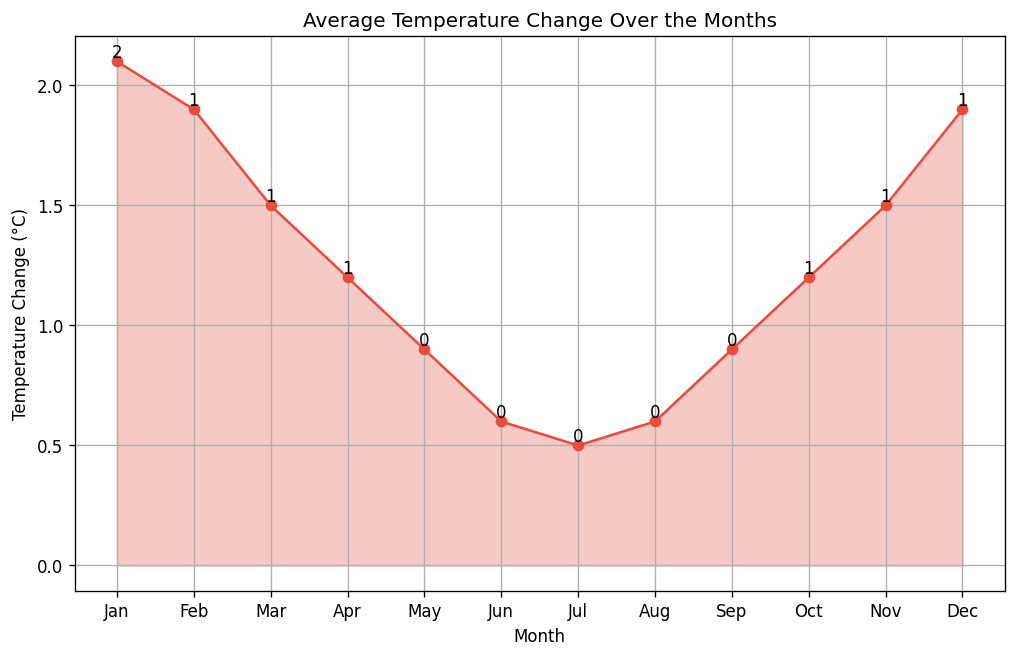

✓ Successfully generated image for sample 0


Evaluating: 100%|██████████| 10/10 [01:41<00:00, 10.20s/it]


EVALUATION SUMMARY
Samples evaluated: 10
Successful generations: 10 (100.0%)
Failed generations: 0 (0.0%)
Gibberish generations: 0 (0.0%)
Syntax valid: 10/10



In [ ]:
ground_truth_images_new = list(ground_truth_images)  # if needed

metrics, failed, generated_images = evaluate_model_data(
    model,
    tokenizer,
    raw_model_data,
    ground_truth_images_new,
    num_samples_eval=10,
    max_new_tokens=1024
)


### Optionally Save Generated Images to Drive

In [ ]:
import os
from PIL import Image

# Create directory in Drive
save_dir = '/content/drive/MyDrive/generated_charts'
os.makedirs(save_dir, exist_ok=True)

# Save all generated images
for idx, img_array in generated_images.items():
    if img_array is not None:
        img = Image.fromarray(img_array.astype('uint8'))
        filepath = os.path.join(save_dir, f'chart_{idx:04d}.png')
        img.save(filepath)
        print(f"✓ Saved chart {idx} to {filepath}")

print(f"\n✅ Saved {len(generated_images)} images to {save_dir}")

✓ Saved chart 0 to /content/drive/MyDrive/generated_charts/chart_0000.png
✓ Saved chart 1 to /content/drive/MyDrive/generated_charts/chart_0001.png
✓ Saved chart 2 to /content/drive/MyDrive/generated_charts/chart_0002.png
✓ Saved chart 3 to /content/drive/MyDrive/generated_charts/chart_0003.png
✓ Saved chart 4 to /content/drive/MyDrive/generated_charts/chart_0004.png
✓ Saved chart 5 to /content/drive/MyDrive/generated_charts/chart_0005.png
✓ Saved chart 6 to /content/drive/MyDrive/generated_charts/chart_0006.png
✓ Saved chart 7 to /content/drive/MyDrive/generated_charts/chart_0007.png
✓ Saved chart 8 to /content/drive/MyDrive/generated_charts/chart_0008.png
✓ Saved chart 9 to /content/drive/MyDrive/generated_charts/chart_0009.png

✅ Saved 10 images to /content/drive/MyDrive/generated_charts


In [ ]:
print(metrics)

{'syntax_correctness': 1.0, 'compilation_success': 1.0, 'execution_success': 1.0, 'image_ssim': 0.7421433224299733, 'pixel_similarity': 0.9529102432070603, 'psnr': 14.393337114896918, 'has_plot_call': 0.8, 'has_xlabel': 0.8, 'has_ylabel': 0.8, 'has_title': 1.0, 'has_legend': 0.5, 'has_grid': 0.8, 'skipped_grid': 0.2, 'code_length': 756.9, 'samples_evaluated': 10, 'num_failed': 0, 'num_successful': 10, 'gibberish_count': 0, 'gibberish_rate': 0.0, 'num_image_comparisons': 10}


## Step 4: Visual Question Answering
We load the Qwen2-VL base model together with our fine-tuned LoRA adapter from Hugging Face Hub. We also display the answers to the questions we have previously created to verify that everything is correct.

In [ ]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from peft import PeftModel

# base + lora model ID
base_model = "Qwen/Qwen2-VL-2B-Instruct"
lora_adapter = "vlaaa13/qwen2vl-2b-chartqa-qlora-2500-v3"

# load base model (quantization / dtype as needed)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    base_model,
    device_map="auto",
    torch_dtype=torch.float16  # or bfloat16, depending on hardware
)

# load the LoRA adapter
model = PeftModel.from_pretrained(model, lora_adapter)

# load processor (tokenizer + image processor)
processor = AutoProcessor.from_pretrained(base_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
answers               # list of ground truth answers (strings)


[{'answer': '0.5'},
 {'answer': 'Yes'},
 {'answer': '10'},
 {'answer': 'May'},
 {'answer': '12000'},
 {'answer': '25.5'},
 {'answer': '2014'},
 {'answer': 'Yes'},
 {'answer': '7'},
 {'answer': 'No'}]

### Run Inference on Chart Images
Now we proceed with evaluating our fine-tuned Qwen2-VL model on the created set of examples.

The run_inference_qwen2vl() function is used for the full inference pipeline:
- it takes in the list of images, questions, and ground-truth answers;
- formats each example using the proper Qwen2-VL message format;
- generates and decodes the answers;
- outputs the predictions, ground truths, questions, and the corresponding indeces.

In [ ]:
from tqdm import tqdm
import torch
from PIL import Image

def run_inference_qwen2vl(
    images,                  # LIST of numpy arrays or PIL Images
    questions,               # LIST of question strings (same order)
    answers,                 # LIST of dicts: {"answer": "..."}
    model,
    processor,
    device="cuda",
    desc="Inference"
):
    predictions = []
    ground_truths = []
    q_list = []
    indices = list(range(len(images)))

    print(f"🔄 Running {desc} on {len(images)} generated chart images...")

    for i in tqdm(range(len(images)), desc=desc):

        img = images[i]
        question = questions[i]["question"].strip()
        gt = answers[i]["answer"].strip()

        # Convert numpy to PIL if needed
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)

        # Qwen2-VL chat message format
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": img},
                    {"type": "text", "text": f"Answer this question about the chart: {question}"}
                ]
            }
        ]

        # Build prompt for Qwen2-VL
        text = processor.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        inputs = processor(
            text=[text],
            images=[img],
            return_tensors="pt",
            padding=True
        ).to(device)

        # Run inference
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_new_tokens=50,
                do_sample=False,  # deterministic evaluation
                pad_token_id=processor.tokenizer.pad_token_id
            )

        # Only decode generated part
        generated_ids = output_ids[0][inputs["input_ids"].shape[1]:]
        pred = processor.decode(generated_ids, skip_special_tokens=True).strip()

        predictions.append(pred)
        ground_truths.append(gt)
        q_list.append(question)

        # Print first 10 samples
        if i < 10:
            print(f"\n--- Example {i+1} ---")
            print(f"Q: {question}")
            print(f"Predicted: {pred}")
            print(f"Ground Truth: {gt}")

    return predictions, ground_truths, q_list, indices

### Evaluation Function
We use the same evaluation metrics and function as when evaluating the fine-tuned vs. base model in Stage 2.

This function computes several accuracy metrics between model predictions and ground-truth answers:

**Exact accuracy:**
  - Lowercase + strip whitespace
  - Predictions must match ground truth exactly

**Relaxed accuracy:**
  - Accepts exact matches or numerically close predictions
  - Helps when LLMs output extra words

**Numeric accuracy:**
  - Only applies when ground truth is numeric
  - Checks whether the model predicts a number close to the true value (5% tolerance)
  - Handles percentages and decimals as equivalent

In [ ]:
import re

def is_numeric_answer(text):
    if text is None:
        return False
    text = text.strip().replace("%", "")
    return bool(re.match(r"^-?\d*\.?\d+$", text))

def numeric_close(pred, gt, tolerance=0.05):
    try:
        p = float(pred.replace("%", ""))
        g = float(gt.replace("%", ""))

        if g == 0:
            return abs(p - g) < 1e-9

        rel_err = abs(p - g) / abs(g)
        return rel_err <= tolerance
    except:
        return False

def evaluate_chartqa_predictions(predictions, answers):
    """
    predictions: list of model outputs (strings)
    answers: list of {"answer": "..."}
    """
    total = len(predictions)

    exact_matches = 0
    relaxed_matches = 0
    numeric_matches = 0
    numeric_total = 0

    for pred, gt_dict in zip(predictions, answers):
        gt = gt_dict["answer"]

        pred_norm = pred.strip().lower()
        gt_norm = gt.strip().lower()

        # 1️⃣ Exact match
        if pred_norm == gt_norm:
            exact_matches += 1

        # 2️⃣ Relaxed match (lowercase or numeric-close)
        relaxed_ok = False
        if pred_norm == gt_norm:
            relaxed_ok = True
        elif is_numeric_answer(pred_norm) and is_numeric_answer(gt_norm):
            if numeric_close(pred_norm, gt_norm):
                relaxed_ok = True
        if relaxed_ok:
            relaxed_matches += 1

        # 3️⃣ Numeric accuracy (percentage-safe)
        if is_numeric_answer(gt_norm):
            numeric_total += 1
            if is_numeric_answer(pred_norm) and numeric_close(pred_norm, gt_norm):
                numeric_matches += 1

    return {
        "total_questions": total,
        "numeric_questions": numeric_total,
        "exact_match_accuracy": 100 * exact_matches / total,
        "relaxed_accuracy": 100 * relaxed_matches / total,
        "numeric_accuracy": 100 * numeric_matches / numeric_total if numeric_total > 0 else 0,
    }


## Fine-Tuned Model Inference and Evaluation
Now we run inference with the fine-tuned Qwen2-VL model on the small set of 10 generated chart images we created with StarCoder2-1B. The predict results are collected and the evaluation metrics are computed using the previously defined functions.


In [ ]:
preds, gts, qs, idxs = run_inference_qwen2vl(
    generated_images,
    questions,
    answers,
    model,
    processor,
    device="cuda",
)

finetuned_metrics = evaluate_chartqa_predictions(preds, answers)

print("📊 FINE-TUNED MODEL RESULTS")
print("="*70)
print(f"Total Questions: {finetuned_metrics['total_questions']}")
print(f"Numeric Questions: {finetuned_metrics['numeric_questions']}")
print(f"\nExact Match Accuracy: {finetuned_metrics['exact_match_accuracy']:.2f}%")
print(f"Relaxed Accuracy: {finetuned_metrics['relaxed_accuracy']:.2f}%")
print(f"Numeric Accuracy: {finetuned_metrics['numeric_accuracy']:.2f}%")


🔄 Running Inference on 10 generated chart images...


Inference:  10%|█         | 1/10 [00:01<00:12,  1.40s/it]


--- Example 1 ---
Q: What is the temperature change in July?
Predicted: 0.5
Ground Truth: 0.5


Inference:  20%|██        | 2/10 [00:02<00:09,  1.20s/it]


--- Example 2 ---
Q: Is United States favourability in China more than China favourability in United States?
Predicted: Yes
Ground Truth: Yes


Inference:  30%|███       | 3/10 [00:03<00:08,  1.22s/it]


--- Example 3 ---
Q: What is the quantity proportion of Mangoes?
Predicted: 0.1
Ground Truth: 10


Inference:  40%|████      | 4/10 [00:04<00:07,  1.18s/it]


--- Example 4 ---
Q: Which month had the most sales?
Predicted: May
Ground Truth: May


Inference:  50%|█████     | 5/10 [00:06<00:06,  1.28s/it]


--- Example 5 ---
Q: What is the Sales amount in Year 2016?
Predicted: 12000
Ground Truth: 12000


Inference:  60%|██████    | 6/10 [00:07<00:05,  1.27s/it]


--- Example 6 ---
Q: What is the popularity of Django?
Predicted: 25.5
Ground Truth: 25.5


Inference:  70%|███████   | 7/10 [00:08<00:03,  1.28s/it]


--- Example 7 ---
Q: When was the highest city temperature in CityY?
Predicted: 2014
Ground Truth: 2014


Inference:  80%|████████  | 8/10 [00:09<00:02,  1.21s/it]


--- Example 8 ---
Q: Is profit of product A more than profit of product B in 2018?
Predicted: Yes
Ground Truth: Yes


Inference:  90%|█████████ | 9/10 [00:11<00:01,  1.21s/it]


--- Example 9 ---
Q: What was the population growth in 2012?
Predicted: 7.1
Ground Truth: 7


Inference: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


--- Example 10 ---
Q: Is the annual revenue of company B more than annual revenue of company A in 2016?
Predicted: No
Ground Truth: No
📊 FINE-TUNED MODEL RESULTS
Total Questions: 10
Numeric Questions: 6

Exact Match Accuracy: 80.00%
Relaxed Accuracy: 90.00%
Numeric Accuracy: 83.33%


### **Results for these 10 examples:**
The results show that 8/10 model's answers exactly match the ground truth, 9/10 answers either exactly match or are numerically close and 83.33% of the answers were within tolerance of the ground truth.

**Observations:**
- The model correctly answered all yes/no questions.
- Numeric answers were mostly correct, though one mismatch (7.1 predicted vs 7 ground truth) slightly reduced numeric accuracy due to decimal representation handling.
- The relaxed and numeric accuracy metrics help capture numeric or near-correct answers that wouldn't count under strict exact match.


## Step 6 - Interactive Demo Cell


### Loading Images and the Model
The following cells load the generated chart images from Google Drive and the fine-tuned Qwen2-VL model from Hugging Face.

- **Images:** Read the PNG files from the generated_charts directory into a dictionary with their indices.
- **Model:** Load the base Qwen2-VL model and apply the LoRA adapter for fine-tuning.
- **Processor:** Load the corresponding tokenizer + image processor to handle text and visual inputs.

In [ ]:
import os
import numpy as np
from PIL import Image

# Load images from Drive
save_dir = '/content/drive/MyDrive/generated_charts'

generated_images = {}

# Read all PNG files in the directory
for filename in sorted(os.listdir(save_dir)):
    if filename.endswith('.png'):
        # Extract index from filename (e.g., chart_0000.png -> 0)
        idx = int(filename.split('_')[1].split('.')[0])

        # Load image
        filepath = os.path.join(save_dir, filename)
        img = Image.open(filepath)
        img_array = np.array(img)

        generated_images[idx] = img_array

print(f"✅ Loaded {len(generated_images)} images from Drive")
print(f"Available indices: {list(generated_images.keys())}")

✅ Loaded 10 images from Drive
Available indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Load model (2.5 min)

In [ ]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from peft import PeftModel

# base + lora model ID
base_model = "Qwen/Qwen2-VL-2B-Instruct"
lora_adapter = "vlaaa13/qwen2vl-2b-chartqa-qlora-2500-v3"

# load base model (quantization / dtype as needed)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    base_model,
    device_map="auto",
    torch_dtype=torch.float16  # or bfloat16, depending on hardware
)

# load the LoRA adapter
model = PeftModel.from_pretrained(model, lora_adapter)

# load processor (tokenizer + image processor)
processor = AutoProcessor.from_pretrained(base_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Interactive Q&A and Visualization
Next we create an interactive interface for chart-based Q&A.
1. Display a grid of charts with a small data preview and  select a chart.
2. Users can type a question about the selected chart.
3. Answer generation: Qwen2-VL: Produce vision-based answers directly from the chart image.


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output

def display_chart_gallery(generated_images, model_data, num_charts=5):
    """Display a gallery of generated charts for selection."""
    available_indices = list(generated_images.keys())[:num_charts]

    print(f"{'='*80}")
    print("🎨 CHART GALLERY - Select a chart to ask questions about")
    print(f"{'='*80}\n")

    # Calculate grid layout
    cols = min(3, len(available_indices))
    rows = (len(available_indices) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    if len(available_indices) == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if rows > 1 else axes

    for i, idx in enumerate(available_indices):
        axes[i].imshow(generated_images[idx])
        axes[i].set_title(f"Chart #{idx}", fontsize=14, fontweight='bold', pad=10)
        axes[i].axis('off')

        # Add data preview below
        sample = model_data[idx]
        data_preview = sample.get("data", "").split('\n')[:3]

        axes[i].text(0.5, -0.05, f"Data: {data_preview[0][:40]}...",
                    transform=axes[i].transAxes, ha='center', fontsize=8, style='italic')

    # Hide extra subplots
    for i in range(len(available_indices), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    return available_indices


def generate_answer_text_model(model, tokenizer, prompt, max_new_tokens=256):
    """Generate an answer using a text-based model."""
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            repetition_penalty=1.1,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the answer part (after "### Answer:")
    if "### Answer:" in generated_text:
        answer = generated_text.split("### Answer:")[-1].strip()
        # Remove any subsequent ### markers
        if "###" in answer:
            answer = answer.split("###")[0].strip()
    else:
        answer = generated_text.strip()

    return answer


def generate_answer_qwen_vl(processor, model, image, question, max_new_tokens=256):
    """
    Generate an answer using Qwen2-VL (vision-language model).

    Args:
        processor: Qwen2VLProcessor
        model: Qwen2VLForConditionalGeneration
        image: numpy array (H, W, 3) of the chart image
        question: The question to ask about the image
        max_new_tokens: Max tokens to generate
    """
    from PIL import Image as PILImage

    # Convert numpy array to PIL Image
    if isinstance(image, np.ndarray):
        pil_image = PILImage.fromarray(image.astype(np.uint8))
    else:
        pil_image = image

    # Create conversation format for Qwen2-VL
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": pil_image},
                {"type": "text", "text": question}
            ]
        }
    ]

    # Prepare inputs
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(
        text=[text],
        images=[pil_image],
        padding=True,
        return_tensors="pt"
    ).to(model.device)

    # Generate answer
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
        )

    # Decode and extract answer
    generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]

    # Extract only the assistant's response
    if "assistant\n" in generated_text:
        answer = generated_text.split("assistant\n")[-1].strip()
    else:
        answer = generated_text.strip()

    return answer


def interactive_chart_qa_colab(generated_images, model_data,
                               qwen_processor, qwen_model,
                               model1=None, tokenizer1=None, model1_name="StarCoder Model",
                               num_charts=5):
    """
    Run an interactive Q&A session using Qwen2-VL for vision-based answers.

    Args:
        generated_images: Dict of generated images
        model_data: List of data samples
        qwen_processor: Qwen2VLProcessor
        qwen_model: Qwen2VLForConditionalGeneration model
        model1: Optional text-based model for comparison
        tokenizer1: Tokenizer for text model
        model1_name: Name for text model
        num_charts: Number of charts to display
    """

    # Get available indices without displaying
    available_indices = list(generated_images.keys())[:num_charts]

    # Create widgets
    chart_dropdown = widgets.Dropdown(
        options=[(f"Chart #{i}", i) for i in available_indices],
        value=available_indices[0],
        description='Select Chart:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='300px')
    )

    question_input = widgets.Textarea(
        value='',
        placeholder='Type your own question here... (e.g., What is the highest value in this chart?)',
        description='Your Question:',
        style={'description_width': '120px'},
        layout=widgets.Layout(width='90%', height='100px')
    )

    ask_button = widgets.Button(
        description='Ask Question',
        button_style='primary',
        icon='question',
        layout=widgets.Layout(width='150px')
    )

    output_area = widgets.Output()

    def on_ask_click(b):
        """Handle ask button click."""
        with output_area:
            clear_output(wait=True)

            chart_idx = chart_dropdown.value
            question = question_input.value.strip()

            if not question:
                print("❌ Please enter a question!")
                return

            sample = model_data[chart_idx]
            csv_data = sample.get("data", "")
            description = sample.get("description", "")

            print(f"\n{'='*80}")
            print(f"❓ Question about Chart #{chart_idx}")
            print(f"{'='*80}\n")

            # Display the chart
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            ax.imshow(generated_images[chart_idx])
            ax.set_title(f"Chart #{chart_idx}", fontsize=14, fontweight='bold')
            ax.axis('off')
            plt.tight_layout()
            plt.show()

            print(f"\n📝 Question: {question}\n")
            print(f"{'='*80}\n")

            # Get answer from Qwen2-VL (vision model)
            print(f"🤖 Qwen2-VL is analyzing the chart...")
            answer_qwen = generate_answer_qwen_vl(
                processor=qwen_processor,
                model=qwen_model,
                image=generated_images[chart_idx],
                question=question,
                max_new_tokens=256
            )

            print(f"\n{'─'*80}")
            print(f"💬 Qwen2-VL Answer (Vision-based):")
            print(f"{'─'*80}")
            print(answer_qwen)
            print(f"{'─'*80}\n")

            # Get answer from text model if provided (for comparison)
            if model1 is not None and tokenizer1 is not None:
                # Create prompt with data context
                prompt = f"""### Task: Answer a question about a chart

### Chart Data:
{csv_data}

### Chart Description:
{description}

### Question:
{question}

### Answer:
"""

                print(f"🤖 {model1_name} is thinking (text-based)...")
                answer_text = generate_answer_text_model(model1, tokenizer1, prompt, max_new_tokens=256)

                print(f"\n{'─'*80}")
                print(f"💬 {model1_name} Answer (Text-based):")
                print(f"{'─'*80}")
                print(answer_text)
                print(f"{'─'*80}\n")

                # Show comparison
                print(f"{'='*80}")
                print("📊 COMPARISON")
                print(f"{'='*80}")
                print(f"✓ Qwen2-VL (vision): {len(answer_qwen)} chars")
                print(f"✓ {model1_name} (text): {len(answer_text)} chars")
                print(f"{'='*80}\n")

    def on_chart_change(change):
        """Handle chart selection change."""
        chart_idx = change['new']
        with output_area:
            clear_output(wait=True)

            # Display selected chart
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            ax.imshow(generated_images[chart_idx])
            ax.set_title(f"Chart #{chart_idx}", fontsize=14, fontweight='bold')
            ax.axis('off')
            plt.tight_layout()
            plt.show()

            # Show data preview
            sample = model_data[chart_idx]
            print(f"\n📊 Chart #{chart_idx} Data Preview:")
            print("─" * 80)
            data_lines = sample.get("data", "").split('\n')[:5]
            print('\n'.join(data_lines))
            if len(sample.get("data", "").split('\n')) > 5:
                print("...")
            print("─" * 80)

            print(f"\n📝 Original Description:")
            print("─" * 80)
            desc = sample.get("description", "")
            print(desc[:300] + "..." if len(desc) > 300 else desc)
            print("─" * 80)

    # Attach event handlers
    ask_button.on_click(on_ask_click)
    chart_dropdown.observe(on_chart_change, names='value')

    # Create charts overview button
    show_gallery_button = widgets.Button(
        description='📊 Show All Charts',
        button_style='info',
        icon='th',
        layout=widgets.Layout(width='200px')
    )

    gallery_output = widgets.Output()

    def on_show_gallery_click(b):
        """Display the chart gallery."""
        with gallery_output:
            clear_output(wait=True)

            # Calculate grid layout
            cols = min(3, len(available_indices))
            rows = (len(available_indices) + cols - 1) // cols

            fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
            if len(available_indices) == 1:
                axes = [axes]
            else:
                axes = axes.flatten() if rows > 1 else axes

            for i, idx in enumerate(available_indices):
                axes[i].imshow(generated_images[idx])
                axes[i].set_title(f"Chart #{idx}", fontsize=14, fontweight='bold', pad=10)
                axes[i].axis('off')

                # Add data preview below
                sample = model_data[idx]
                data_preview = sample.get("data", "").split('\n')[:3]

                axes[i].text(0.5, -0.05, f"Data: {data_preview[0][:40]}...",
                            transform=axes[i].transAxes, ha='center', fontsize=8, style='italic')

            # Hide extra subplots
            for i in range(len(available_indices), len(axes)):
                axes[i].axis('off')

            plt.tight_layout()
            plt.show()

    show_gallery_button.on_click(on_show_gallery_click)

    # Layout
    header = widgets.HTML(
        value="<h2>🎨 Interactive Chart Q&A Demo</h2>"
              "<p>Select a chart and type your question to compare model responses!</p>"
    )

    ui = widgets.VBox([
        header,
        widgets.HTML(value="<hr>"),
        show_gallery_button,
        gallery_output,
        widgets.HTML(value="<br>"),
        chart_dropdown,
        widgets.HTML(value="<h3>✍️ Type Your Question:</h3>"),
        question_input,
        ask_button,
        widgets.HTML(value="<hr>"),
        output_area
    ], layout=widgets.Layout(padding='10px'))

    display(ui)

    # Automatically show gallery on load
    on_show_gallery_click(None)

    # Trigger initial display of first chart
    on_chart_change({'new': available_indices[0]})

In [ ]:
interactive_chart_qa_colab(
    generated_images=generated_images,
    model_data=model_data,
    qwen_processor=processor,  # Use your processor
    qwen_model=model,          # Use your LoRA-adapted model
    num_charts=5
)

## Run Inference on Ground Truth Images
Additionally, we run the fine-tuned model on the ground-truth charts to optionally compare its performance against the generated charts. We computes the same metrics as before.

In [ ]:
preds, gts, qs, idxs = run_inference_qwen2vl(
    ground_truth_images,
    questions,
    answers,
    model,
    processor,
    device="cuda",
)

finetuned_metrics = evaluate_chartqa_predictions(preds, answers)

print("📊 FINE-TUNED MODEL RESULTS")
print("="*70)
print(f"Total Questions: {finetuned_metrics['total_questions']}")
print(f"Numeric Questions: {finetuned_metrics['numeric_questions']}")
print(f"\nExact Match Accuracy: {finetuned_metrics['exact_match_accuracy']:.2f}%")
print(f"Relaxed Accuracy: {finetuned_metrics['relaxed_accuracy']:.2f}%")
print(f"Numeric Accuracy: {finetuned_metrics['numeric_accuracy']:.2f}%")

🔄 Running Inference on 10 generated chart images...


Inference:  10%|█         | 1/10 [00:03<00:30,  3.44s/it]


--- Example 1 ---
Q: What is the temperature change in July?
Predicted: 0.5
Ground Truth: 0.5


Inference:  20%|██        | 2/10 [00:04<00:16,  2.03s/it]


--- Example 2 ---
Q: Is United States favourability in China more than China favourability in United States?
Predicted: No
Ground Truth: Yes


Inference:  30%|███       | 3/10 [00:07<00:18,  2.69s/it]


--- Example 3 ---
Q: What is the quantity proportion of Mangoes?
Predicted: 0.1
Ground Truth: 10


Inference:  40%|████      | 4/10 [00:10<00:16,  2.77s/it]


--- Example 4 ---
Q: Which month had the most sales?
Predicted: May
Ground Truth: May


Inference:  50%|█████     | 5/10 [00:14<00:14,  2.98s/it]


--- Example 5 ---
Q: What is the Sales amount in Year 2016?
Predicted: 12000
Ground Truth: 12000


Inference:  60%|██████    | 6/10 [00:17<00:12,  3.03s/it]


--- Example 6 ---
Q: What is the popularity of Django?
Predicted: 25.5
Ground Truth: 25.5


Inference:  70%|███████   | 7/10 [00:20<00:09,  3.03s/it]


--- Example 7 ---
Q: When was the highest city temperature in CityY?
Predicted: 2014
Ground Truth: 2014


Inference:  80%|████████  | 8/10 [00:20<00:04,  2.23s/it]


--- Example 8 ---
Q: Is profit of product A more than profit of product B in 2018?
Predicted: No
Ground Truth: Yes


Inference:  90%|█████████ | 9/10 [00:22<00:02,  2.03s/it]


--- Example 9 ---
Q: What was the population growth in 2012?
Predicted: 7.0
Ground Truth: 7


Inference: 100%|██████████| 10/10 [00:22<00:00,  2.30s/it]


--- Example 10 ---
Q: Is the annual revenue of company B more than annual revenue of company A in 2016?
Predicted: No
Ground Truth: No
📊 FINE-TUNED MODEL RESULTS
Total Questions: 10
Numeric Questions: 6

Exact Match Accuracy: 60.00%
Relaxed Accuracy: 70.00%
Numeric Accuracy: 83.33%
